In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [2]:
import gymnasium as gym
import math
import time
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from alive_progress import alive_bar
from IPython.display import clear_output, display as ipy_display

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

gym.envs.registration.register(
    id='F1Env-v0',
    entry_point='environments.car_env:F1_Env',
)
env = gym.make('F1Env-v0')

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Using existing resized image from: ../cars/car2d_30_30.png
Using existing resized image from: ../tracks/track01_1920_1080.png


In [3]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        # Define the architecture
        self.fc1 = nn.Linear(input_dim, 256)  # First fully connected layer
        self.fc2 = nn.Linear(256, 128)  # Second fully connected layer
        self.fc3 = nn.Linear(128, 64)  # Third fully connected layer
        self.fc4 = nn.Linear(64, output_dim)  # Output layer
        
        # Batch normalization layers
        self.bn1 = nn.InstanceNorm1d(256)
        self.bn2 = nn.InstanceNorm1d(128)
        self.bn3 = nn.InstanceNorm1d(64)

        # Dropout for regularization
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # Forward pass through the network
        x = F.leaky_relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)  # Apply dropout
        x = F.leaky_relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)  # Apply dropout
        x = F.leaky_relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)  # No activation function on the output layer
        return x


In [5]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

input_dim = 8  # Total number of elements in the observation tensor
output_dim = env.action_space.n  # Number of actions
# Get number of actions from gym action space
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(input_dim, output_dim).to(device)
target_net = DQN(input_dim, output_dim).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)

steps_done = 0


def select_action(state):
    global steps_done  # Keeps track of the number of steps (actions selected)
    sample = random.random()  # Generates a random sample for epsilon-greedy strategy

    # Calculate the epsilon threshold for the current step using exponential decay
    # Starts from EPS_START and decays towards EPS_END at a rate determined by EPS_DECAY
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
                    math.exp(-1. * steps_done / EPS_DECAY)

    steps_done += 1  # Increment the steps_done counter

    # Decision making for choosing an action based on epsilon-greedy strategy
    if sample > eps_threshold:
        # Exploitation: Choose the best action based on current policy
        with torch.no_grad():  # Disable gradient calculation for inference
            # The policy network predicts the Q-values for all actions given the current state
            # .max(1) finds the action with the highest Q-value
            # .indices.view(1, 1) formats the chosen action for compatibility with environment
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        # Exploration: Choose a random action
        # This allows the agent to explore the action space and discover new strategies
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []

def plot_durations(episode_durations, show_result=False):
    clear_output(wait=True)  # Clear the output of the current cell receiving output
    plt.figure(figsize=(10, 5))  # Create a new figure
    plt.title('Training Progress' if not show_result else 'Final Result')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.plot(durations_t.numpy(), label="Episode Duration")
    
    if len(durations_t) >= 50:
        means = durations_t.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(49), means))
        plt.plot(means.numpy(), label="Moving Average (50 episodes)")
    
    plt.legend()
    plt.grid(True)
    ipy_display(plt.gcf())  # Display the current figure using the correctly referenced display function
    plt.close()  # Close the figure to prevent it from being displayed directly in the notebook

In [6]:
def optimize_model():
    # Check if enough samples are available in memory to create a batch
    if len(memory) < BATCH_SIZE:
        return  # Not enough samples, skip this round of optimization

    # Sample a batch of transitions from memory
    transitions = memory.sample(BATCH_SIZE)

    # This clever trick transposes the batch of transitions to a Transition of batch-arrays.
    # It effectively organizes the data for easy batch processing.
    batch = Transition(*zip(*transitions))

    # Create a mask for non-final states (i.e., states that are not the end of an episode)
    # and a tensor for holding non-final next states
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    # Concatenate all states, actions, and rewards into separate tensors
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) for each action taken in the batch
    # This step involves forward passing the state_batch through the policy_net
    # and using gather to select the Q-values for the actions actually taken
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Initialize a tensor for the next state values with zeros for all batch samples
    # This will be updated with the predicted Q values for non-final states
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    # Compute V(s_{t+1}) for all non-final next states using the target network
    # The max predicted Q value for the next states are selected with max(1).values
    # This operation is wrapped in torch.no_grad() to prevent gradient computation
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    # Compute the expected Q values for the current state-action pairs
    # This is done by adding the (discounted) best future rewards to the immediate rewards
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute the loss between the current Q values and the expected Q values
    # The Huber loss is used here, which is less sensitive to outliers than squared error loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Zero all gradients for the variables which the optimizer will update
    optimizer.zero_grad()
    # Calculate the gradients of the loss with respect to all parameters
    # in the policy network involved in its computation
    loss.backward()
    # Clip gradients to prevent very large values which can destabilize training
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    # Perform a single optimization step (parameter update)
    optimizer.step()


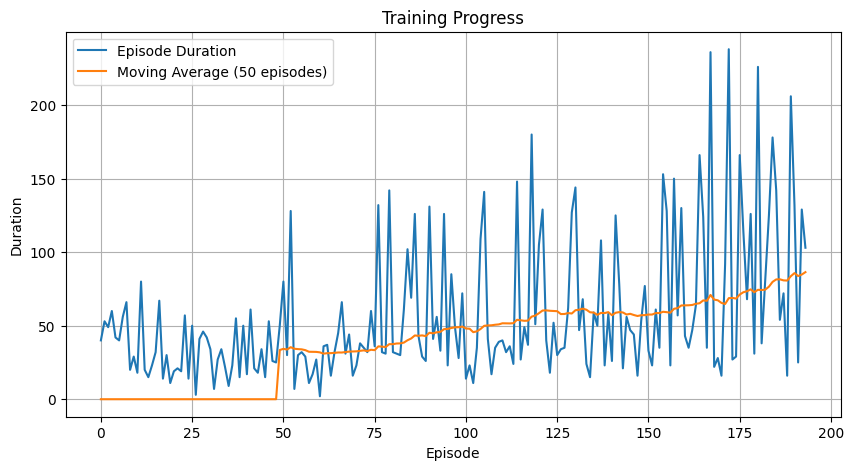

on 193: Episode 193 completed in 1.18 seconds.


In [ ]:
def obs_to_tensor(observation, device):
    # Convert observation dictionary values to tensors with consistent shapes
    position = torch.tensor(observation['position'], device=device, dtype=torch.float32).view(1, -1)
    angle = torch.tensor(observation['angle'], device=device, dtype=torch.float32).view(1, -1)
    speed = torch.tensor(observation['speed'], device=device, dtype=torch.float32).view(1, -1)
    distances_to_edges = torch.tensor(observation['distances_to_edges'], device=device, dtype=torch.float32).view(1, -1)

    # Concatenate along dimension 1 (columns) after ensuring all tensors are 2D (1, N)
    return torch.cat((position, angle, speed, distances_to_edges), dim=1)

def pick_best_results_and_name_model(episode_durations, model_base_name="model"):
    # Placeholder for your result picking logic 
    # Let's assume you want the results with the longest duration
    best_episode_index = episode_durations.index(max(episode_durations))
    best_duration = episode_durations[best_episode_index]

    # Construct the model name using an f-string
    model_name = f"{model_base_name}_episode_{best_episode_index}_duration_{best_duration}.pth"

    return model_name 


if torch.cuda.is_available():
    num_episodes = 10000
else:
    num_episodes = 50
    
total_start_time = time.time()  # Track the start time of the training

with alive_bar(num_episodes, title="Training Progress", bar="smooth") as bar:
    for i_episode in range(num_episodes):
        episode_start_time = time.time()  # Episode start time
        # Initialize the environment and get its state
        state, info = env.reset()
        state = obs_to_tensor(state, device=device)
        
        for t in count():
            action = select_action(state)
            observation, reward, terminated, truncated, _ = env.step(action.item())
            reward = torch.tensor([reward], device=device)
            done = terminated or truncated

            if terminated:
                next_state = None
            else:
                next_state = obs_to_tensor(observation, device=device)
    
            memory.push(state, action, next_state, reward)
    
            state = next_state
    
            # Perform  step of the optimization (on the policy network)
            optimize_model()
    
            # Soft update of the target network's weights
            # θ′ ← τ θ + (1 −τ )θ′
            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
            target_net.load_state_dict(target_net_state_dict)
    
            if done:
                episode_durations.append(t + 1)
                plot_durations(episode_durations)
                model_name = pick_best_results_and_name_model(episode_durations)  # Get the model name
                torch.save(policy_net.state_dict(), model_name)  # Save the model
                episode_end_time = time.time()  # Episode end time
                episode_time_elapsed = episode_end_time - episode_start_time
                print(f"Episode {i_episode} completed in {episode_time_elapsed:.2f} seconds.")
                bar()  # Update the progress bar
                break

total_end_time = time.time()  # Track the end time of the training
total_time_elapsed = total_end_time - total_start_time
print(f'Total training time: {total_time_elapsed:.2f} seconds.')

print('Complete')
plot_durations(episode_durations, show_result=True)
plt.ioff()
plt.show()